In [1]:
reset -fs

In [2]:
#NLTK
import nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')
  
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

#Gensim
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

from collections import Counter
import string

#sklearn
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer



#pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

#Other
import pandas as pd
import numpy as np
import re, string
import zipfile
import os
import matplotlib 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mariavasilenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mariavasilenko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data pre-processing

- Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
- Words that have fewer than 3 characters are removed.
- All stopwords are removed.
 - Stop words list has been extended after running a baseline LDA model 
- Words are __stemmed__ — words are reduced to their root form.


In [21]:
# Create the list of stopwords and extend it 

stopwords = list(ENGLISH_STOP_WORDS)
# Adding "just" after running basic LDA model
'''newStopWords = ['just', 'like', 'love', 'good','better', 'great','easi', 'nice', 'awesom', 'thank', 'simpl',\
                'wast', 'highli', 'useless', 'conveni', 'friendli', 'finger',
                'doe', 'doesn', 'work', 'user', 'use', 'need', 'tri', 'time']
#stopwords.extend(newStopWords)'''


def tokenize(text):
    """
    Tokenize text and return a non-unique list of tokenized words
    found in the text.
    Normalize to lowercase, strip punctuation,
    remove stop words, drop words of length < 3.
    """
    
    text=text.lower() #Convert everything to lowercase
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)  # delete stuff but leave at least a space to avoid clumping together
    words =  nltk.word_tokenize(nopunct) # tokenizing words
    words_token = [w for w in words if len(w) > 3]  # Drop words less than length 3
    words_token[:] = [w for w in words_token if w != '']
    words_stop = [w for w in words_token if w not in stopwords] # Removes stop words using SciKit-Learn's ENGLISH_STOP_WORDS set.
    words_res = [w.encode('ascii','ignore') for w in words_stop]
    return words_res

def stemwords(words):
    """
    Given a list of tokens/words, return a new list with each word
    stemmed using a PorterStemmer.
    """
    stemmer = PorterStemmer()
    words = [w.decode('ascii','ignore') for w in words]
    stemmed = [stemmer.stem(w) for w in words]
    stemmed_filtered = [w for w in stemmed if w not in stopwords]
    return stemmed_filtered

    
def tokenizer(text):
    
    return stemwords(tokenize(text))


In [22]:
df_reviews = pd.read_csv('data/amazon_all_reviews.csv')

In [1]:
df_reviews['name'].value_counts()

NameError: name 'df_reviews' is not defined

In [24]:
# Create a dataframe with negative reviews
df_neg_reviews = df_reviews[df_reviews['rating']<=3]

In [25]:
#Create dataframe with positive reviews
df_pos_reviews = df_reviews[df_reviews['rating']>3]

In [26]:
len(df_neg_reviews)

713

In [27]:
len(df_pos_reviews)

1626

In [28]:
assert len(df_neg_reviews) + len(df_pos_reviews) == len(df_reviews)

In [29]:
# Extract text of negative reviews
neg_reviews_text = df_neg_reviews['text']
neg_text = list(neg_reviews_text)

In [30]:
# Extract the text of positive reviews
pos_reviews_text = df_pos_reviews['text']
pos_text = list(pos_reviews_text)

In [31]:
neg_clean_text = [tokenizer(n_t) for n_t in neg_text]

In [32]:
pos_clean_text = [tokenizer(p_t) for p_t in pos_text]

In [33]:
# Adding bi-grams and tri-grams to negative reviews

from gensim.models.phrases import Phrases, Phraser
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phraser(Phrases(neg_clean_text, min_count=10))
trigram = Phrases(bigram[neg_clean_text])

for idx in range(len(neg_clean_text)):
    for token in bigram[neg_clean_text[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            neg_clean_text[idx].append(token)
    for token in trigram[neg_clean_text[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            neg_clean_text[idx].append(token)

/anaconda3/envs/uhc_env/lib/python3.7/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [34]:
# Adding bigrams and trigrams to positive reviews

from gensim.models.phrases import Phrases, Phraser
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phraser(Phrases(pos_clean_text, min_count=10))
trigram = Phrases(bigram[pos_clean_text])

for idx in range(len(pos_clean_text)):
    for token in bigram[pos_clean_text[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            pos_clean_text[idx].append(token)
    for token in trigram[pos_clean_text[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            pos_clean_text[idx].append(token)

#### Remove empty tokens

In [35]:
for item in neg_clean_text:
    item[:] = [elem for elem in item if elem != ""]


In [36]:
for item in pos_clean_text:
    item[:] = [elem for elem in item if elem != ""]


#### Create the dictionary

In [37]:
#Creating the dictionary out of corpus of negative reviews
neg_dictionary = corpora.Dictionary(neg_clean_text)

In [38]:
# Creating the dictionary out of corpus of positive reviews
pos_dictionary = corpora.Dictionary(pos_clean_text)

In [39]:
len(neg_dictionary)

2585

In [40]:
len(pos_dictionary)

2911

In [41]:
# Hyperparameters

NUM_NEG_TOPICS =5 # Number of topics in negative reviews
NUM_POS_TOPICS =5 # Number of topics in positive reviews
# PArameters used in filtering the dictionaries
MIN_DF= 2 # remove tokens that appear in less than MIN_DF docs
MAX_DF = 0.5 # Remove tokens that appear in more than MAX_DF * 100% of docs

In [42]:
# Filter extremes:
# Filter tokens that appear in less than 2 doc-s
# Filter out tokens that appear in more than 30% of docs

neg_dictionary.filter_extremes(no_below=MIN_DF, no_above= MAX_DF)
pos_dictionary.filter_extremes(no_below=MIN_DF, no_above= MAX_DF)


In [43]:
len(neg_dictionary)

1421

In [44]:
len(pos_dictionary)

1661

#### Create word term matrix

In [45]:
neg_doc_term_mx = [neg_dictionary.doc2bow(doc) for doc in neg_clean_text]

In [46]:
pos_doc_term_mx = [pos_dictionary.doc2bow(doc) for doc in pos_clean_text]

### LDA model training

In [47]:
# LDA for negative reviews

neg_lda = gensim.models.ldamodel.LdaModel(corpus=neg_doc_term_mx, \
                                      id2word=neg_dictionary, num_topics=NUM_NEG_TOPICS, random_state = 17) \
                                      #, update_every=1, chunksize=100, passes=50)

In [48]:
# LDA for positive reviews

pos_lda = gensim.models.ldamodel.LdaModel(corpus=pos_doc_term_mx, \
                                      id2word=pos_dictionary, num_topics=NUM_POS_TOPICS, random_state = 17) \
                                      #, update_every=1, chunksize=100, passes=50)

In [49]:
# Topics based on negative reviews
neg_lda.print_topics(num_words=20)

[(0,
  '0.017*"result" + 0.015*"like" + 0.015*"ancestri" + 0.014*"andm" + 0.012*"test" + 0.012*"money" + 0.011*"health" + 0.011*"custom_servic" + 0.011*"inform" + 0.010*"just" + 0.010*"sampl" + 0.009*"time" + 0.008*"stolen_credit" + 0.007*"purchas" + 0.007*"servic" + 0.007*"kit" + 0.007*"disappoint" + 0.007*"receiv" + 0.006*"wast_time" + 0.006*"report"'),
 (1,
  '0.025*"result" + 0.017*"test" + 0.014*"custom_servic" + 0.014*"report" + 0.010*"andm" + 0.009*"servic" + 0.008*"just" + 0.008*"week" + 0.008*"sampl" + 0.008*"tell" + 0.008*"provid" + 0.007*"ancestri" + 0.007*"health" + 0.007*"want" + 0.006*"data" + 0.006*"money" + 0.006*"said" + 0.006*"time" + 0.006*"custom" + 0.006*"inform"'),
 (2,
  '0.022*"result" + 0.016*"ancestri" + 0.016*"test" + 0.015*"report" + 0.015*"health" + 0.013*"wast_money" + 0.012*"money" + 0.012*"know" + 0.011*"inform" + 0.011*"like" + 0.010*"sampl" + 0.008*"week" + 0.008*"receiv" + 0.007*"didn" + 0.007*"wast" + 0.007*"wait" + 0.006*"custom_servic" + 0.006*"dis

In [50]:
#Visualize negative topics
pyLDAvis.gensim.prepare(neg_lda, neg_doc_term_mx, neg_dictionary, R = 20)

/anaconda3/envs/uhc_env/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.006215 -0.018256       1        1  32.497269
4     -0.005881 -0.029550       2        1  23.650515
1      0.009158 -0.012055       3        1  16.225441
0     -0.038095  0.033277       4        1  15.155989
3      0.041033  0.026584       5        1  12.470785, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
389   Default  201.000000     wast_money  201.000000  20.0000  20.0000
121   Default  331.000000           test  331.000000  19.0000  19.0000
14    Default  421.000000         result  421.000000  18.0000  18.0000
87    Default   89.000000          month   89.000000  17.0000  17.0000
350   Default   31.000000  stolen_credit   31.000000  16.0000  16.0000
35    Default  148.000000  custom_servic  148.000000  15.0000  15.0000
22    Default   66.000000      wast_time   66.000000  14.0000  14.0000
46    Default  223.000000         inform  223.000000  13.0000  13.0000
190   Default  154.000000           andm  154.000000  12.0000  12.0000
293   Default  187.000000         health  187.000000  11.0000  11.0000
66    Default   84.000000         servic   84.000000  10.0000  10.0000
52    Default  185.000000           like  185.000000   9.0000   9.0000
15    Default   89.000000           said   89.000000   8.0000   8.0000
48    Default  142.000000           just  142.000000   7.0000   7.0000
2     Default  215.000000       ancestri  215.000000   6.0000   6.0000
10    Default   58.000000            kit   58.000000   5.0000   5.0000
344   Default   18.000000         stolen   18.000000   4.0000   4.0000
19    Default  123.000000           time  123.000000   3.0000   3.0000
54    Default   47.000000          medic   47.000000   2.0000   2.0000
376   Default   41.000000     total_wast   41.000000   1.0000   1.0000
1192   Topic1    4.105820            box    4.827882   0.9620  -7.3170
486    Topic1    7.523344          estim    9.637152   0.8764  -6.7114
107    Topic1    4.367708         forget    5.723368   0.8537  -7.2552
906    Topic1    6.516419         combin    8.638583   0.8421  -6.8551
1365   Topic1    2.149981     membership    2.871285   0.8347  -7.9640
1412   Topic1    3.562230         reciev    4.801569   0.8255  -7.4591
1194   Topic1    2.123687          fraud    2.869103   0.8232  -7.9763
1059   Topic1    4.961215          exist    6.713948   0.8215  -7.1278
898    Topic1    2.054712         outcom    2.866689   0.7910  -8.0093
891    Topic1    2.708038           pool    3.811848   0.7821  -7.7332
...       ...         ...            ...         ...      ...      ...
376    Topic5   11.928903     total_wast   41.725830   0.8296  -5.2927
130    Topic5    3.053945    month_later    7.930208   1.1275  -6.6552
121    Topic5   62.268772           test  331.430450   0.4098  -3.6402
54     Topic5   13.074085          medic   47.832951   0.7847  -5.2010
8      Topic5    8.864950           gave   30.024233   0.8619  -5.5896
14     Topic5   67.471352         result  421.918915   0.2487  -3.5600
15     Topic5   20.138933           said   89.585785   0.5892  -4.7690
46     Topic5   38.480335         inform  223.920090   0.3206  -4.1215
22     Topic5   14.775834      wast_time   66.158096   0.5827  -5.0787
311    Topic5   14.536951       question   65.147926   0.5818  -5.0950
137    Topic5   19.439684        compani  102.346664   0.4207  -4.8044
455    Topic5    6.637831            rel   21.778946   0.8936  -5.8789
131    Topic5   14.593820          order   68.512306   0.5354  -5.0911
72     Topic5   10.508543          total   43.038467   0.6719  -5.4195
295    Topic5   15.978891         realli   86.859116   0.3888  -5.0004
293    Topic5   25.519745         health  187.131638   0.0894  -4.5322
40     Topic5    9.997917         expect   42.155155   0.6428  -5.4693
108    Topic5   12.273329    


The left panel of the chart presents a global view of topics: how they are related to each other (far apart or inmtersect) and how preevalent they are (the larger the circle the more prevalent is the topic). 

THe right panel shows  the individual terms that are the most useful for interpreting the currently selected topic on the left.  A pair of overlaid bars represent both the corpus-wide frequency ofa given term as well as the topic-specific frequency of the term.

Parameter lambda regulates the _relevance_ of the term, which is used to rank terms within topics. It is regulated by parameter _lambda_.
- If _lambda_ = 1, we'll see familiar ranking of terms in decreasing order of their topic-specific probability
- If _lambda_ = 0, we'll rank words soleley by their _lift_, defined as the ratio of a term’s probability within a topic to its marginal probability across the corpus. In other words, it helps determine the words exclusivity to a particular topic. 

In [51]:
# Topics based on positive reviews
pos_lda.print_topics()

[(0,
  '0.031*"test" + 0.020*"result" + 0.019*"health" + 0.014*"know" + 0.011*"great" + 0.010*"ancestri" + 0.008*"genet" + 0.008*"just" + 0.007*"like" + 0.007*"inform"'),
 (1,
  '0.031*"result" + 0.016*"love" + 0.015*"inform" + 0.014*"report" + 0.013*"ancestri" + 0.009*"test" + 0.009*"great" + 0.008*"easi" + 0.008*"receiv" + 0.008*"health"'),
 (2,
  '0.034*"result" + 0.018*"test" + 0.015*"ancestri" + 0.015*"inform" + 0.013*"health" + 0.011*"receiv" + 0.011*"great" + 0.011*"wait" + 0.009*"report" + 0.009*"like"'),
 (3,
  '0.040*"result" + 0.022*"test" + 0.021*"inform" + 0.018*"ancestri" + 0.015*"health" + 0.014*"easi" + 0.014*"famili" + 0.011*"like" + 0.009*"genet" + 0.009*"report"'),
 (4,
  '0.024*"result" + 0.013*"highli_recommend" + 0.011*"genet" + 0.011*"know" + 0.011*"good" + 0.011*"easi" + 0.010*"famili_member" + 0.009*"health" + 0.009*"test" + 0.009*"famili"')]

In [52]:
#Visualize positive topics
pyLDAvis.gensim.prepare(pos_lda, pos_doc_term_mx, pos_dictionary, R = 20)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.003818 -0.025583       1        1  32.478081
0     -0.006503 -0.008616       2        1  20.502623
2     -0.035502  0.024205       3        1  17.879503
1      0.008113 -0.011107       4        1  16.625574
4      0.037710  0.021101       5        1  12.514226, topic_info=     Category         Freq              Term        Total  loglift  logprob
term                                                                       
462   Default   195.000000              love   195.000000  20.0000  20.0000
103   Default   146.000000              good   146.000000  19.0000  19.0000
485   Default   117.000000     famili_member   117.000000  18.0000  18.0000
113   Default   220.000000  highli_recommend   220.000000  17.0000  17.0000
133   Default   271.000000              know   271.000000  16.0000  16.0000
886   Default   111.000000         want_know   111.000000  15.0000  15.0000
254   Default   632.000000              test   632.000000  14.0000  14.0000
272   Default   168.000000              wait   168.000000  13.0000  13.0000
205   Default   286.000000            report   286.000000  12.0000  12.0000
273   Default    77.000000       wait_result    77.000000  11.0000  11.0000
656   Default    63.000000        great_deal    63.000000  10.0000  10.0000
208   Default  1013.000000            result  1013.000000   9.0000   9.0000
125   Default   113.000000              info   113.000000   8.0000   8.0000
652   Default   105.000000              gift   105.000000   7.0000   7.0000
533   Default   125.000000            expect   125.000000   6.0000   6.0000
640   Default    95.000000       easi_follow    95.000000   5.0000   5.0000
92    Default   256.000000            famili   256.000000   4.0000   4.0000
881   Default   110.000000    famili_histori   110.000000   3.0000   3.0000
1417  Default    62.000000      look_forward    62.000000   2.0000   2.0000
104   Default   282.000000             great   282.000000   1.0000   1.0000
1537   Topic1     2.183774       nonetheless     2.929746   0.8307  -8.4857
1598   Topic1     2.182344        specialist     2.929677   0.8301  -8.4864
1123   Topic1     2.181905             unabl     2.929621   0.8299  -8.4866
1167   Topic1     2.181391             delux     2.929600   0.8297  -8.4868
1165   Topic1     2.180334           exposur     2.929503   0.8292  -8.4873
1587   Topic1     2.166759          pleasant     2.928118   0.8235  -8.4936
1568   Topic1     2.860025           astound     3.881270   0.8193  -8.2160
1491   Topic1    30.407873         peac_mind    41.509762   0.8134  -5.8521
1490   Topic1    11.321073              peac    15.470216   0.8124  -6.8401
1042   Topic1     4.947531          outstand     6.933068   0.7872  -7.6679
...       ...          ...               ...          ...      ...      ...
113    Topic5    54.886463  highli_recommend   220.847122   0.6861  -4.3078
374    Topic5    14.371686            member    48.324337   0.8656  -5.6478
866    Topic5     9.536806            profil    29.116304   0.9622  -6.0579
101    Topic5    46.639614             genet   259.926331   0.3604  -4.4706
620    Topic5    11.500002             arriv    40.916298   0.8091  -5.8707
133    Topic5    46.609669              know   271.335663   0.3168  -4.4713
382    Topic5    20.280106    nativ_american    91.154114   0.5754  -5.3034
176    Topic5    11.208534           possibl    41.120037   0.7785  -5.8964
67     Topic5    18.000204            diseas    80.238701   0.5837  -5.4227
170    Topic5    17.884914             peopl    79.839981   0.5822  -5.4291
189    Topic5    17.095234          question    75.249870   0.5963  -5.4743
964    Topic5    24.883148         took_week   131.662842   0.4123  -5.0989
642    Topic5    12.199401          european    47.501736   0.7189  -5.8117
208    Topic5    97.196716            result  1013.122253  -0.2658  -3.7364
533    

### Coherence score

In [53]:
# Compute Coherence Score
coherence_neg_lda = CoherenceModel(model=neg_lda, texts=neg_clean_text, dictionary= neg_dictionary,  coherence='c_v')
coherence_lda = coherence_neg_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)




Coherence Score:  0.3621612179973135


In [54]:
coherence_pos_lda = CoherenceModel(model=pos_lda, texts=pos_clean_text, dictionary= pos_dictionary,  coherence='c_v')
coherence_lda = coherence_pos_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)




Coherence Score:  0.4176246672909779


In [55]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1, random_state = 17):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state = random_state)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


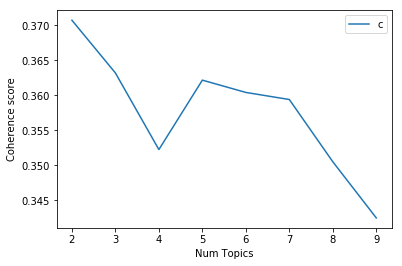

In [57]:

model_list, coherence_values = compute_coherence_values( corpus= neg_doc_term_mx, dictionary = neg_dictionary, texts = neg_clean_text, limit = 10 );
# Show graph
import matplotlib.pyplot as plt
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show();


Source: 
- [https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/]
- [https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/]

In [58]:
# LDA for negative reviews
NUM_NEG_TOPICS = 2 # 
neg_lda = gensim.models.ldamodel.LdaModel(corpus=neg_doc_term_mx, \
                                      id2word=neg_dictionary, num_topics=NUM_NEG_TOPICS, random_state = 17) \
                                      #, update_every=1, chunksize=100, passes=50)
neg_lda.print_topics()

[(0,
  '0.021*"result" + 0.015*"inform" + 0.015*"test" + 0.014*"ancestri" + 0.014*"like" + 0.013*"wast_money" + 0.012*"money" + 0.011*"health" + 0.009*"andm" + 0.009*"sampl"'),
 (1,
  '0.024*"result" + 0.020*"test" + 0.013*"report" + 0.011*"week" + 0.009*"ancestri" + 0.009*"health" + 0.008*"know" + 0.008*"inform" + 0.008*"custom_servic" + 0.008*"wast_money"')]

Negative topics:

- Topic 0: insurance card, test_result. Unique words (lambda =0):  error_occur, garmin ==> TECHNICAL ISSUES: issues with SYNC, ERROR MESSAGES
- Topic 1: custom service, p/w, login==>  BAD CUSTOM SERVICE, issues with login/password
- Topic 2: screen, uninstall-reinstall. Unique words (lambda =0): uninstall/reeinstall, VIEW CLAIM  ==> VIEW CLAIMS
- Topic 3:URGENT CARE
- Topic 4:  issues with LOGIN/PASSWORD, PRESCRIPT, ORDER.  ==> PRESCRIPTIONS
- Topic 5: health insuranvce, make appointments. Unique: white screen, username/p/w
- Topic 6: messages
- Topic 7: SCHEDULE APPOINTMENTS, MAKE PAYMENTS

In [59]:
pyLDAvis.gensim.prepare(neg_lda, neg_doc_term_mx, neg_dictionary, R = 20)

/anaconda3/envs/uhc_env/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x    y  topics  cluster      Freq
topic                                          
1      0.013416  0.0       1        1  53.60112
0     -0.013416  0.0       2        1  46.39888, topic_info=     Category        Freq              Term       Total  loglift  logprob
term                                                                     
52    Default  182.000000              like  182.000000  20.0000  20.0000
46    Default  219.000000            inform  219.000000  19.0000  19.0000
22    Default   65.000000         wast_time   65.000000  18.0000  18.0000
389   Default  190.000000        wast_money  190.000000  17.0000  17.0000
129   Default  177.000000             money  177.000000  16.0000  16.0000
622   Default   57.000000      saliva_sampl   57.000000  15.0000  15.0000
2     Default  211.000000          ancestri  211.000000  14.0000  14.0000
350   Default   32.000000     stolen_credit   32.000000  13.0000  13.0000
23    Default  151.000000              week  151.000000  12.0000  12.0000
495   Default   33.000000  eastern_european   33.000000  11.0000  11.0000
90    Default  134.000000            receiv  134.000000  10.0000  10.0000
21    Default  119.000000              wast  119.000000   9.0000   9.0000
225   Default   58.000000         want_know   58.000000   8.0000   8.0000
376   Default   41.000000        total_wast   41.000000   7.0000   7.0000
270   Default   15.000000             south   15.000000   6.0000   6.0000
295   Default   86.000000            realli   86.000000   5.0000   5.0000
247   Default   19.000000             asian   19.000000   4.0000   4.0000
91    Default  148.000000             sampl  148.000000   3.0000   3.0000
499   Default   36.000000   answer_question   36.000000   2.0000   2.0000
273   Default  106.000000              tell  106.000000   1.0000   1.0000
709    Topic1    4.317510             grand    4.883810   0.5004  -7.7672
906    Topic1    7.628165            combin    8.772676   0.4838  -7.1980
495    Topic1   28.437323  eastern_european   33.092991   0.4720  -5.8822
1174   Topic1    3.286870            afford    3.885847   0.4562  -8.0399
1352   Topic1    7.274543              plan    8.727820   0.4415  -7.2455
82     Topic1    6.382169              fals    7.747396   0.4298  -7.3763
1376   Topic1    3.912272        comprehens    4.832408   0.4124  -7.8657
288    Topic1    4.689881            stress    5.798275   0.4114  -7.6844
1196   Topic1    3.121455            safari    3.864866   0.4100  -8.0916
688    Topic1    3.120408               fit    3.864733   0.4097  -8.0919
...       ...         ...               ...         ...      ...      ...
271    Topic2    6.679092       south_asian    8.961883   0.4739  -7.1866
264    Topic2    8.634262             popul   11.657501   0.4677  -6.9298
622    Topic2   40.393364      saliva_sampl   57.697838   0.4113  -5.3869
52     Topic2  120.178947              like  182.177887   0.3519  -4.2966
46     Topic2  134.938004            inform  219.762421   0.2802  -4.1807
344    Topic2   13.405437            stolen   18.910114   0.4239  -6.4899
387    Topic2   10.356274            unless   14.386990   0.4392  -6.7480
376    Topic2   27.726677        total_wast   41.660049   0.3607  -5.7632
389    Topic2  111.996948        wast_money  190.318970   0.2377  -4.3671
129    Topic2  103.672661             money  177.623215   0.2295  -4.4443
21     Topic2   71.600800              wast  119.709740   0.2539  -4.8145
2      Topic2  120.223228          ancestri  211.967926   0.2008  -4.2962
90     Topic2   79.146935            receiv  134.504974   0.2376  -4.7143
499    Topic2   23.940308   answer_question   36.250805   0.3530  -5.9100
295    Topic2   50.055309            realli   86.090714   0.2256  -5.1724
91     Topic2   80.584465             sampl  148.201172   0.1586  -4.6963
293    Topic2   97.472389            health  186.469681   0.1192  -4.5060
190    Topic2   81.375534              andm  155.038773   0.1233 

#### Determine the dominant topic for each review

In [60]:
for i, row in enumerate(neg_lda[neg_doc_term_mx]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
            # Get the Dominant topic, Percentage Contribution and Keywords for each document
    for j, (topic_num, topic_prop) in enumerate(row):
        if j == 0:  # => dominant topic
            word_prop = neg_lda.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, proportion in word_prop])
            
            #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        else:
            break

In [61]:
def format_topics_documents(ldamodel, corpus, texts):
    # Init output
    doc_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Percentage Contribution and Keywords for each document
        for j, (topic_num, topic_prop) in enumerate(row):
            if j == 0:  # => dominant topic
                word_prop = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in word_prop])
                doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(topic_prop,3), topic_keywords]), ignore_index=True)
            else:
                break
    doc_topics_df.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    doc_topics_df = pd.concat([doc_topics_df, contents], axis=1)
    return(doc_topics_df)


In [62]:

df_topic_docs_keywords = format_topics_documents(ldamodel=neg_lda, corpus=neg_doc_term_mx, texts= neg_text )

# Format
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['doc_no', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'text']

# Show
df_dominant_topic.head(10)

,doc_no,dominant_topic,topic_perc_contrib,keywords,text
0,0,0.0,0.971,"result, inform, test, ancestri, like, wast_mon...",I had to submit DNA twice and both times they ...
1,1,0.0,0.559,"result, inform, test, ancestri, like, wast_mon...",We bought two kits. My husband got his back in...
2,2,1.0,0.939,"result, test, report, week, ancestri, health, ...",It has been 2 and a half months since they rec...
3,3,1.0,0.812,"result, test, report, week, ancestri, health, ...",Caution! Quidado! Achtung!\n\nIf your ethnicit...
4,4,0.0,0.781,"result, inform, test, ancestri, like, wast_mon...",I purchased this kit in Dec 2017. I received a...
5,5,1.0,0.916,"result, test, report, week, ancestri, health, ...",Packaging and saliva submission process was pr...
6,6,1.0,0.568,"result, test, report, week, ancestri, health, ...",We have had nothing but problems with 23 and m...
7,7,1.0,0.981,"result, test, report, week, ancestri, health, ...",I purchased this as a Christmas gift for my fa...
8,8,1.0,0.767,"result, test, report, week, ancestri, health, ...","One star, not because of the product, as I've ..."
9,9,0.0,0.896,"result, inform, test, ancestri, like, wast_mon...","I'd like to say this is a great test, but it's..."


#### Find the most representative review for each topic


In [63]:
# Group top 3 sentences under each topic
doc_topics_sorted_df = pd.DataFrame()

doc_topics_df_grouped = df_topic_docs_keywords.groupby('dominant_topic')

for i, grp in doc_topics_df_grouped:
    doc_topics_sorted_df = pd.concat([doc_topics_sorted_df, 
                                             grp.sort_values(['perc_contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
doc_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
doc_topics_sorted_df.columns = ['topic_Num', "topic_perc_contrib", "keywords", "text"]

# Show
pd.set_option('max_colwidth',1000)

doc_topics_sorted_df.head(10)

,topic_Num,topic_perc_contrib,keywords,text
0,0.0,0.997,"result, inform, test, ancestri, like, wast_money, money, health, andm, sampl","If you want a bunch of useless, trivial information about yourself, buy it. But a lot is outright wrong. What is correct is utterly useless information that I ALREADY KNEW ABOUT MYSELF because a MIRROR was invented for some time now. The ""health"" information is just stupid and most of it is information about health in general that they use to fluff up and pad their report to justify your cost. Want to know how trivial and useless? Here are some of my results all bunched together:\n\nAsparagus Odor Detection-->Likely can smell(WTF?); Bald Spot-->Likely no bald spot(Wrong!Unfortunately); Earlobe Type-->Likely detached earlobes(Correct!And I really hate it when I lose one of my detached earlobes.I look funny all day.); Early Hair Loss-->Likely no hair loss(Wrong!Again!Just started Minoxidil;Crossing fingers); Earwax Type-->Likely wet earwax(I guess so.Can't compare to what dry is and don't want to find out); Eye Color-->Likely brown or hazel eyes(Correct!); Finger Length Ratio-->Likel..."
1,1.0,0.995,"result, test, report, week, ancestri, health, know, inform, custom_servic, wast_money","I didn’t purchase Vitagene through Amazon, but through their website. I was hoping to gain some insight into which health practices I can adopt to function optimally. The service is fast. I received my results in a little over 3 weeks. I was astounded and a bit confused about my ancestry results. I have always known that I am mostly European (Eastern Europe, Italy, and Scotland), but my results were different. It says that I am mostly Central European, and Eastern European. But I am also Jewish from Spain/Portugal! This was news to me and I am so excited to now further explore my Jewish ancestry. But no mention of Scotland or Italy, which I thought was odd. I just bought a more detailed test from abother company that tests both paternal, maternal and autosomal DNA with migratory patterns. The health information is garbage. They first have you fill out your profile info with your height/weight and eating/excessive habits. Part of the health report includes your BMI (which you can’t ..."


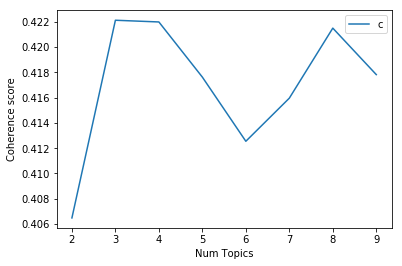

In [64]:
#Positive reviews coherence score

model_list, coherence_values = compute_coherence_values( corpus= pos_doc_term_mx, dictionary = pos_dictionary, texts = pos_clean_text, limit = 10 );
# Show graph
import matplotlib.pyplot as plt
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show();


In [65]:
# LDA for positive reviews
NUM_POS_TOPICS = 4
pos_lda = gensim.models.ldamodel.LdaModel(corpus=pos_doc_term_mx, \
                                      id2word=pos_dictionary, num_topics=NUM_POS_TOPICS, random_state = 17) \
                                      #, update_every=1, chunksize=100, passes=50)

In [66]:
pos_lda.print_topics(20)

[(0,
  '0.029*"test" + 0.019*"result" + 0.018*"health" + 0.015*"know" + 0.009*"ancestri" + 0.009*"great" + 0.009*"genet" + 0.008*"just" + 0.007*"like" + 0.007*"realli"'),
 (1,
  '0.029*"result" + 0.014*"report" + 0.013*"love" + 0.013*"inform" + 0.012*"ancestri" + 0.010*"great" + 0.009*"good" + 0.008*"test" + 0.008*"easi" + 0.008*"receiv"'),
 (2,
  '0.032*"result" + 0.017*"test" + 0.013*"ancestri" + 0.013*"inform" + 0.012*"health" + 0.012*"great" + 0.010*"wait" + 0.010*"receiv" + 0.009*"report" + 0.009*"know"'),
 (3,
  '0.039*"result" + 0.021*"test" + 0.020*"inform" + 0.017*"ancestri" + 0.015*"easi" + 0.015*"health" + 0.014*"famili" + 0.011*"like" + 0.010*"highli_recommend" + 0.009*"genet"')]

__Suggested topics based on positive reviews__
- Topic 0 (2): health information. Exclusive words:  chronic, treatment ==> FEATURE: access to  HEALTH INFO, TREATMENT
- Topic 1 (6): TEST RESULTS,  MEDICAL HISTORY
- Topic 2 (1):medical record, doctor appointments. Esclusive: MEDICAL RECORD ==> DOCTOR APPOINTMENTS , MEDICAL RECORD
- Topic 3 (4): doctor, doctor_office, insurance card. Exclusive: insur card. ==> FEAUTURE: in-app Insurance card info?
- Topic 4 (9): easy to navigate, medical records ==> access to MEDICAL RECORDS
- Topic 5 (8): tracl, test results. Exclusive: sleep, exercise, trust. ==> FEAUTURE: TEST RESULTS, TRACKING SLEEP and EXERCISE
- Topic 6 (5): doctor, save, drug, message, send message. Exclusive: distance, code, regist. ==> FEAUTURE: MESSAGING to DOCTOR
- Topic 7 (7): test result,m appoint, refill prescription. Esxclusive: blood sugar, heart rate ==> Feature: REFILL PRESCRIPTION, HEART RATE, TEST RESULTS (blood sugar, radiology)
- Topic 8 (3): similar



In [67]:
#Visualize positive topics
pyLDAvis.gensim.prepare(pos_lda, pos_doc_term_mx, pos_dictionary, R = 20)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.019024 -0.022547       1        1  36.061848
0      0.000295 -0.004228       2        1  22.850863
2      0.033478 -0.000680       3        1  20.840254
1     -0.014749  0.027455       4        1  20.247042, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
254   Default   629.000000            test   629.000000  20.0000  20.0000
462   Default   194.000000            love   194.000000  19.0000  19.0000
886   Default   110.000000       want_know   110.000000  18.0000  18.0000
272   Default   166.000000            wait   166.000000  17.0000  17.0000
133   Default   272.000000            know   272.000000  16.0000  16.0000
205   Default   285.000000          report   285.000000  15.0000  15.0000
656   Default    63.000000      great_deal    63.000000  14.0000  14.0000
1417  Default    61.000000    look_forward    61.000000  13.0000  13.0000
273   Default    77.000000     wait_result    77.000000  12.0000  12.0000
125   Default   114.000000            info   114.000000  11.0000  11.0000
104   Default   280.000000           great   280.000000  10.0000  10.0000
103   Default   149.000000            good   149.000000   9.0000   9.0000
533   Default   126.000000          expect   126.000000   8.0000   8.0000
881   Default   110.000000  famili_histori   110.000000   7.0000   7.0000
652   Default   104.000000            gift   104.000000   6.0000   6.0000
698   Default    55.000000       spit_tube    55.000000   5.0000   5.0000
640   Default    96.000000     easi_follow    96.000000   4.0000   4.0000
208   Default  1009.000000          result  1009.000000   3.0000   3.0000
686   Default   109.000000           price   109.000000   2.0000   2.0000
132   Default   215.000000            just   215.000000   1.0000   1.0000
1491   Topic1    34.848980       peac_mind    42.139759   0.8300  -5.8204
1490   Topic1    12.832952            peac    15.677412   0.8197  -6.8194
1568   Topic1     3.146202         astound     3.916269   0.8010  -8.2253
1537   Topic1     2.230351     nonetheless     2.931570   0.7466  -8.5693
1165   Topic1     2.221290         exposur     2.930937   0.7427  -8.5734
1167   Topic1     2.220422           delux     2.930783   0.7424  -8.5738
1123   Topic1     2.218054           unabl     2.930753   0.7413  -8.5748
1587   Topic1     2.189831        pleasant     2.927299   0.7297  -8.5876
1598   Topic1     2.180601      specialist     2.930046   0.7245  -8.5919
1183   Topic1     2.902905            laid     3.901937   0.7242  -8.3057
...       ...          ...             ...          ...      ...      ...
462    Topic4    86.378357            love   194.164062   0.7872  -4.3355
315    Topic4    16.947962        daughter    35.892525   0.8468  -5.9641
640    Topic4    41.838024     easi_follow    96.100449   0.7656  -5.0604
103    Topic4    59.937893            good   149.696793   0.6819  -4.7009
278    Topic4    25.988199            work    60.735962   0.7483  -5.5366
815    Topic4    18.706810            hope    42.842659   0.7685  -5.8653
913    Topic4    28.785467      super_easi    70.699242   0.6986  -5.4344
125    Topic4    43.554214            info   114.009590   0.6349  -5.0202
533    Topic4    47.696793          expect   126.501373   0.6218  -4.9294
205    Topic4    92.783997          report   285.609253   0.4728  -4.2640
652    Topic4    37.716579            gift   104.187759   0.5811  -5.1641
981    Topic4    21.510176     worth_money    55.024727   0.6579  -5.7257
213    Topic4    21.475433            said    57.839390   0.6064  -5.7273
519    Topic4    17.954691        christma    46.689842   0.6415  -5.9064
274    Topic4    46.977180            want   158.008591   0.3842  -4.9446
208    Topic4   193.516525          result  1009.987366  -0.0552  -3.5289
110    

In [68]:
pos_df_topic_docs_keywords= format_topics_documents(ldamodel=pos_lda, corpus=pos_doc_term_mx, texts= pos_text )

# Format
pos_df_dominant_topic = pos_df_topic_docs_keywords.reset_index()
pos_df_dominant_topic.columns = ['doc_no', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'text']

# Show
pos_df_dominant_topic.head(5)

,doc_no,dominant_topic,topic_perc_contrib,keywords,text
0,0,1.0,0.654,"result, report, love, inform, ancestri, great, good, test, easi, receiv","Oct 2018 Update adds Alzheimer's section at end.\n\nI had DNA analysis from 23andme. My wife had DNA analysis from both Ancestry(Anc) and 23andme. This review is my comparison of the two. I highly recommend secondary analysis of your results by Promethease, see further discussion at end of this review. Basically I like 23andme. If 23andme offers a lower cost ancestry only test, this is OK. For developing an ancestry tree, Ancestry.com is MUCH better IF you signup separately for Ancestry's subscription search service. Do not use Anc & Promethease for Alzheimer's - see discussion at end of this review.\n\nTAKING TEST and SIGNUP – Very similar test taking. 23’s signup was more secure. Anc’s was easier, but they automatically put my wife’s test on my previously existing Ancestry account.\n\nWaiting on RESULTS – Both send emails confirming sample receipt and when results were available. After logon, 23 provided step by step progress reports on the analysis process. The analysis process ..."
1,1,3.0,0.640,"result, test, inform, ancestri, easi, health, famili, like, highli_recommend, genet",The testing is fairly simple: You receive a test vial (log in and register it on their website) and provide saliva up to the control line. Make sure you don't eat or drink for 30 to 45 minutes before providing your saliva sample. It is best not to brush teeth beforehand since it will only wash away valuable DNA and you want to ensure your sample has enough to process. Yes I had a few failed kits in my life and that set us back months of getting results on those kits. Anyway it’s fairly simple to provide saliva samples. Simple enough I had my 5 1/2 year old done and she was the easiest one to process. Then you place the kit back into included return envelope and wait for about 6 to 8 weeks for it to process. All while keeping tabs of the process online as each step finishes.\n\nI started using 23andme in 2012 before the FDA had gotten nasty and demanded they stop providing such detailed health analysis. Most of the kits I purchased (all but 2) included the ancestry with health but t...
2,2,2.0,0.920,"result, test, ancestri, inform, health, great, wait, receiv, report, know","Excellent, but I would get the $99 kit over the $199 one. Then go to Promethease.com and dna.land.com and import your results (when their available from 23andMe), For $5.00 they give you loads of medical and other misc. insights from your genetic information. Importing is quick and easy, do it right from the Promethease website (links to 23andMe directly and grabs your data. dna.land requires you to upload data yourself). Just be sure to download a copy of the final results to your computer for future reference (as Promethease will automatically delete information from their servers after 4 months). DNA.LAND is free (it's a research project) well worth the extra effort and produces some more interesting results."
3,3,0.0,0.462,"test, result, health, know, ancestri, great, genet, just, like, realli","Found out my husband of 35 years is my sixth cousin, eeew!!!!!! No lie! Now I spend my days trying to figure out the link. We bought two of these and he did it as well. He found out he is a descendant of Lewis, as in Lewis and Clark! He met a cool cousin he never knew he had (other than me, lol).\n\nThe traits were a bit off. I love cilantro for example and it suggested I wouldn't. Little things.\n\nIt asks you a bunch of questions before you get your report, like hair color, eye color, health history, weight, age, etc., then you get a report that says you likely have red hair,......no duh 🙄"
4,4,1.0,0.912,"result, report, love, inform, ancestri, great, good, test, easi, receiv","I bought this for my husband.. the results are AWESOME and he loves it. However, I am apparently married to a Neanderthal."


In [70]:
# Most representative reviews for each topics
pos_doc_topics_sorted_df = pd.DataFrame()

pos_doc_topics_df_grouped = pos_df_topic_docs_keywords.groupby('dominant_topic')

for i, grp in pos_doc_topics_df_grouped:
    pos_doc_topics_sorted_df = pd.concat([pos_doc_topics_sorted_df, 
                                             grp.sort_values(['perc_contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
pos_doc_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
pos_doc_topics_sorted_df.columns = ['topic_num', "topic_perc_contrib", "keywords", "text"]

# Show
pd.set_option('max_colwidth',1000)

pos_doc_topics_sorted_df.head(10)

,topic_num,topic_perc_contrib,keywords,text
0,0.0,0.994,"test, result, health, know, ancestri, great, genet, just, like, realli","I did the Ancestry DNA test before this one and I wasn't happy with the results. I thought they were too vague and generalized. I know both my parents and I wanted to see how 23andme would come out.\nThis kit took less than 3 weeks to get results and I was glad I took it. My mother is 100% Bosnian and I tested at 49.5% Southern European, which is true. The AncestryDNA test had me at 27% Eastern European (which is more Slovakia/Russia/Poland) and 17% Italy/Greece (maybe a better designation for this would be the Mediterranean). Anc does not have a designation for Southern European.\nAncestryDNA found me at 42% West Asian and I have no Asian blood whatsoever. I am Egyptian on my father's side where 23andme found me to be more precise North Africa 36%/Middle East 5%. The rest was broadly Southern Europe. AncestryDNA has a designation for North Africa but it is more Northwest Africa (Tunisia, Algeria, Morocco) and did not include Egypt.\nIn this aspect, I am glad that I took this test...."
1,1.0,0.992,"result, report, love, inform, ancestri, great, good, test, easi, receiv","Timelines are a little wonky. I sent mine in and it was received December 7th. My husbands was received December 8th. His results came in on around January 15th. I still not have received mine though it is, just barely, still within the timeline of 6-8 weeks.\n\nThat said, I've viewed the results for my husband and it's very interesting to look through. I think we knew what we were going to see and weren't surprised to get the results he did. The predisposition to diseases was at least an interesting read, though they stress that environment and other factors play a big role in your chances of actually acquiring any of the mentioned diseases/disorders.\n\nUPDATE: On the first day over 8 weeks, I sent an email to customer support saying that I hadn't seen any progress from essentially step 2 after they receive it and just wanted an update. I received a very courteous response saying that they were moving my sample to the front and that I would be receiving a free code for another ki..."
2,2.0,0.991,"result, test, ancestri, inform, health, great, wait, receiv, report, know","I have been wanting to look into my DNA for months now, ever since the fad has hit the market. I thought that I would just want to know my background, but this DNA kit is much more than just finding out your genetics. This DNA kit gave me an insight of everything that I needed to know regarding my genetics and health profiles.\nI had my first baby over 6 months ago and have been having a hard time losing this baby weight. It has never been an issue for me to lose weight, in fact I have been thin most of my life, so this added weight put a damper on my mood, especially when dieting and exercising was not helping. After utilizing this DNA kit, and finding out more about my body, it has helped me find out what I need to do with my diet plans to help me lose this baby weight. Since changing my dieting rituals to coincide with my genetics, it has helped me lose weight and get back into my pre-baby weight and clothes!\nThis kit was so easy to use. All you have to do is take the swaps, sw..."
3,3.0,0.995,"result, test, inform, ancestri, easi, health, famili, like, highli_recommend, genet","I ordered directly from the Vitagene website, but the review applies.\nSpeed: They were very fast. Entire time, from ordering the kit to getting results took one month. That appears to be faster than any other company.\n\nWhat do you get? Well, you will no longer get a printed book. They stopped providing those for kits ordered after Aug 2017. So disregard earlier reviews touting that benefit. You do get your results online.\n\nThere is a health results section, which is based on a combination of your questionnaire answers (health goals and family history) and your DNA results. There a

In [3]:
-log(0.9)

NameError: name 'log' is not defined